In [1]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
from tqdm import tqdm

In [3]:
import gym

env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([0.04427858, 0.00995939, 0.04138815, 0.01184731], dtype=float32)

In [4]:
# Check the dict of all the environments available
gym.envs.registry.all()

dict_values([EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v1), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v1), EnvSpec(FrozenLake-v1), EnvSpec(FrozenLake8x8-v1), EnvSpec(CliffWalking-v0), EnvSpec(Taxi-v3), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSpec(Swimmer-v3), EnvSpec(Walker2d-v2), EnvSpec(Walker2d-v3), EnvSpec(Ant-v2), EnvSpec(Ant-v3), EnvSpec(Humanoid-v2), EnvSpec(Humanoid-v3), EnvSpec(HumanoidStandup-v2), EnvSpec(FetchSlide-v1), EnvSpec(FetchPickAndPlace-v1), EnvSpec(FetchReach-v1), EnvSpec(FetchPush-v1), EnvSpec(HandReach-v0), EnvSpec(HandManipula

In [5]:
# render
env.render()

True

In [6]:
# Return the rendered image
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [7]:
env.action_space

Discrete(2)

Try accelerating right

In [8]:
action = 1 # accelerate right
obs, reward, done, info = env.step(action)

In [9]:
obs

array([ 0.04447776,  0.2044641 ,  0.04162509, -0.26749524], dtype=float32)

In [10]:
reward

1.0

In [11]:
done

False

In [12]:
info

{}

A simple policy

In [13]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [14]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [15]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.228, 8.960581231147899, 24.0, 68.0)

Visualize one episode

In [16]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [17]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [18]:
plot_animation(frames)

In [19]:
# Close the environment
# env.close()

# Neural Network Policies

In [20]:
import tensorflow as tf
from tensorflow import keras

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

## Policy Gradients

In [21]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1,1]) > left_proba) # boolean
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) # 0->1, 1->0
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    # env.render()
    obs, reward, done, info = env.step(int(action[0,0].numpy()))
    return obs, reward, done, grads

In [22]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [23]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [24]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [25]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [26]:
# Hyperparameters
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [27]:
# Optimizer and loss function
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
for iteration in tqdm(range(n_iterations)):
    # print("Iteration #%d" % iteration)
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

100%|██████████| 150/150 [18:33<00:00,  7.43s/it]


Put the PG model to test

In [29]:
def PG_policy(obs):
    left_proba = model(obs[np.newaxis])
    action = (tf.random.uniform([1,1]) > left_proba) # boolean
    return int(np.squeeze(action.numpy())[()])

In [30]:
totals = []
for episode in tqdm(range(500)):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = PG_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

100%|██████████| 500/500 [04:09<00:00,  2.00it/s]


In [31]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(192.656, 17.89775583697576, 93.0, 200.0)

In [32]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = PG_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [33]:
plot_animation(frames)

# Markov Decision Processes

In [34]:
# The MDP in Fig.18-8
transition_probabilities = [ # shape=[s, a, s']
                            [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
                            [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
                            [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
            [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
            [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
            [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [35]:
# Initialize the Q-values
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # for all possible actions

In [36]:
gamma = 0.90 # the discount factor
history1 = [] # Not shown in the book (for the figure below)

for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = \
                np.sum([ transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma*np.max(Q_prev[sp])) 
                         for sp in range(3) ])
            
history1 = np.array(history1) # Not shown

In [37]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [38]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

## Q-Learning

In [39]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [40]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [41]:
# Initialize the Q-values
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # for all possible actions

In [42]:
alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state

In [43]:
history2 = [] # Not shown in the book

for iteration in tqdm(range(10000)):
    history2.append(Q_values.copy()) # Not shown
    action =exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay) # learning rate decay, using power scheduling
    Q_values[state, action] *= (1- alpha)
    Q_values[state, action] += alpha * (reward + gamma * next_value)
#     Q_values[state, action] += alpha * ( (reward + gamma * next_value) - Q_values[state, action]) # Note: slower!
    state = next_state
    
history2 = np.array(history2) # Not shown

100%|██████████| 10000/10000 [00:06<00:00, 1589.22it/s]


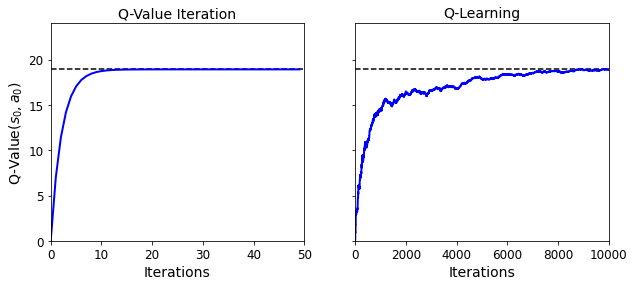

In [44]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

# save_fig("q_value_plot")

# Approximate Q-Learning and Deep Q-Learning
## Implementing Deep Q-Learning

In [45]:
env = gym.make("CartPole-v0")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

In [46]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [47]:
def epsilon_greedy_policy(state, epsilon=0, model=model):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [48]:
# Replay buffer
from collections import deque

replay_buffer = deque(maxlen=2000)

In [49]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [50]:
def play_one_step(env, state, epsilon, model=model):
    action = epsilon_greedy_policy(state, epsilon, model=model)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [51]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean( loss_fn(target_Q_values, Q_values) )
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [52]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

total_rewards = [] 
# best_score = 0

In [53]:
for episode in tqdm(range(600)):
    obs = env.reset()
    total_reward = 0.0
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon, model=model)
        total_reward += reward
        if done:
            break
    total_rewards.append(total_reward) # Not shown in the book # Note: reward == step in this case
    if episode > 50:
        training_step(batch_size)

100%|██████████| 600/600 [24:25<00:00,  2.44s/it]


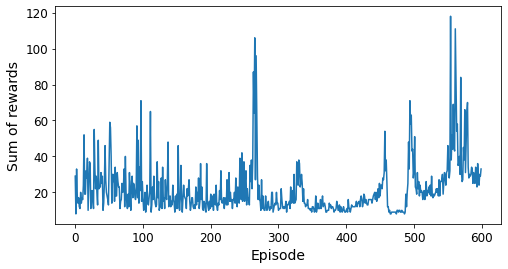

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(total_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
# save_fig("dqn_rewards_plot")
plt.show()

# Deep Q-Learning Variants
## Fixed Q-Value Targets

In [55]:
# The online model
model_online = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [56]:
# The target model
model_target = keras.models.clone_model(model_online)
model_target.set_weights(model_online.get_weights())

In [57]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step_fixedQ(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_target.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model_online(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean( loss_fn(target_Q_values, Q_values) )
    grads = tape.gradient(loss, model_online.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_online.trainable_variables))

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [58]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

total_rewards = [] 
# best_score = 0

In [59]:
for episode in tqdm(range(600)):
    obs = env.reset()
    total_reward = 0.0
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon, model=model_online)
        total_reward += reward
        if done:
            break
    total_rewards.append(total_reward) # Not shown in the book # Note: reward == step in this case
    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            model_target.set_weights(model_online.get_weights())

100%|██████████| 600/600 [12:06<00:00,  1.21s/it]


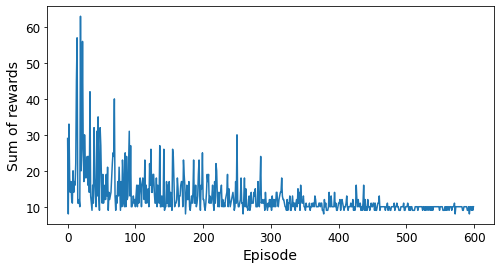

In [60]:
plt.figure(figsize=(8, 4))
plt.plot(total_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
# save_fig("dqn_rewards_plot")
plt.show()

Try it out!

In [63]:
def fDQN_policy(obs):
    state = obs
    action = epsilon_greedy_policy(state, 0.0, model=model_online)
    return action

In [65]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = fDQN_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [66]:
plot_animation(frames)

## Double DQN

In [ ]:
# The online model
model_online = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [ ]:
# The target model
model_target = keras.models.clone_model(model_online)
model_target.set_weights(model_online.get_weights())

In [67]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step_fixedQ(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # -- Fixed Q-value Targets
    # next_Q_values = model_target.predict(next_states) 
    # next_best_Q_values = np.max(next_Q_values, axis=1)
    # -- Double DQN
    next_Q_values = model_online.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (model_target.predict(next_states) * next_mask).sum(axis=1)
    #
    target_Q_values = (rewards + 
                       (1 - dones) * discount_factor * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model_online(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean( loss_fn(target_Q_values, Q_values) )
    grads = tape.gradient(loss, model_online.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_online.trainable_variables))

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [68]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

total_rewards = [] 
# best_score = 0

In [69]:
for episode in tqdm(range(600)):
    obs = env.reset()
    total_reward = 0.0
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon, model=model_online)
        total_reward += reward
        if done:
            break
    total_rewards.append(total_reward) # Not shown in the book # Note: reward == step in this case
    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            model_target.set_weights(model_online.get_weights())

100%|██████████| 600/600 [12:52<00:00,  1.29s/it]


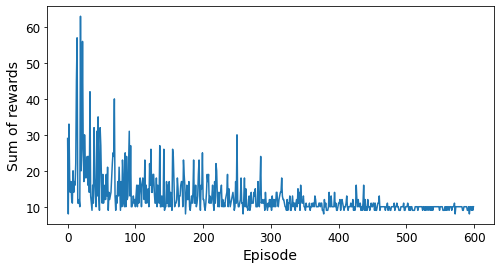

In [70]:
plt.figure(figsize=(8, 4))
plt.plot(total_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
# save_fig("dqn_rewards_plot")
plt.show()

In [71]:
def fDQN_policy(obs):
    state = obs
    action = epsilon_greedy_policy(state, 0.0, model=model_online)
    return action

In [72]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = fDQN_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [73]:
plot_animation(frames)

## Dueling DQN

In [74]:
K = keras.backend

input_states = keras.layers.Input(shape=[4])
# Core
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
# Braching
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
# Calculate advantages
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
# Compose the output (Q-value)
Q_values = state_values + advantages

# Create the model (online)
model_online = keras.Model(inputs=[input_states], outputs=[Q_values])

In [75]:
# The target model
model_target = keras.models.clone_model(model_online)
model_target.set_weights(model_online.get_weights())

In [76]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step_fixedQ(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # -- Fixed Q-value Targets
    # next_Q_values = model_target.predict(next_states) 
    # next_best_Q_values = np.max(next_Q_values, axis=1)
    # -- Double DQN
    next_Q_values = model_online.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (model_target.predict(next_states) * next_mask).sum(axis=1)
    #
    target_Q_values = (rewards + 
                       (1 - dones) * discount_factor * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model_online(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean( loss_fn(target_Q_values, Q_values) )
    grads = tape.gradient(loss, model_online.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_online.trainable_variables))

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [77]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

total_rewards = [] 
# best_score = 0

In [78]:
for episode in tqdm(range(600)):
    obs = env.reset()
    total_reward = 0.0
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon, model=model_online)
        total_reward += reward
        if done:
            break
    total_rewards.append(total_reward) # Not shown in the book # Note: reward == step in this case
    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            model_target.set_weights(model_online.get_weights())

100%|██████████| 600/600 [11:38<00:00,  1.16s/it]


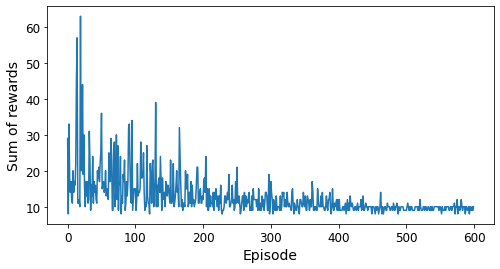

In [79]:
plt.figure(figsize=(8, 4))
plt.plot(total_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
# save_fig("dqn_rewards_plot")
plt.show()

In [80]:
def DDQN_policy(obs):
    state = obs
    action = epsilon_greedy_policy(state, 0.0, model=model_online)
    return action

In [81]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = DDQN_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [82]:
plot_animation(frames)